In [1]:
import os
from pathlib import Path

import jax
import jax.numpy as jnp
from jax import tree_util, random

import jax_md_mod
from jax_md import space, energy, partition, simulate

import optax

import matplotlib.pyplot as plt

from chemtrain.data import preprocessing
from chemtrain.trainers import ForceMatching, RelativeEntropy
from chemtrain import ensemble, quantity

base_path = Path(os.environ.get("DATA_PATH", "./data"))

# Relative Entropy Minimization

## Principle of Relative Entropy

Relative entropy provides a fundamental link between models of different scales [^Shell2008].
Measuring the loss of information induced by the coarse-graining [^Carmichael2012], it is thus a desirable objective to minimize.

For a corase-grained model $p^\text{CG}_\theta(\mathbf R)$ on coarse-grained sites $\mathbf R$ connected to the sites of a fine-scale model $p^\text{AA}(\mathbf r)$ via a mapping $\mathbf R = M(\mathbf r)$, the relative entropy is [^Carmichael2012]

$$
S_\text{rel} = S_\text{map} + \int p^\text{AA}(\mathbf r)\log \frac{p^\text{AA}(\mathbf r)}{p^\text{CG}(M(\mathbf r))}d\mathbf r.
$$


For a canonical ensemble $p(\mathbf r) \propto e^{-\beta U(\mathbf r)}$ at temperature $T = \frac{1}{k_B \beta}$, the relative entropy further decomposes to

$$
S_\text{rel} = S_\text{map} + \beta \left\langle U_\theta^\text{CG}(M(\mathbf r)) - U^\text{AA}(\mathbf r)\right\rangle_\text{AA} - \beta(A_\theta^\text{CG} - A^\text{AA}).
$$

The first part $S_\text{rel}$ measures the unavoidable loss of information due to the degeneracy of the mapping.
This part is, however, independent of the fine-grained and coarse-grained distributions.

The second part is the expected difference between the predicted potential energies $U_\theta^\text{CG}(M(\mathbf r)) - U^\text{AA}(\mathbf r)$ in the fine-scaled ensemble.
This part is simple to estimate.
Analogous to force-matching, the estimation involves pre-computing an atomistic trajectory, followed by a batched gradient-based optimization.

The last part is the free energy difference between the fine-scaled and coarse-grained ensembles.
Since the free energy normalizes a distribution 

$$
A_\theta = -\frac{1}{\beta}\log \int e^{-\beta U_\theta}dx,
$$
it is not a quantity directly predictable from individual samples of the potential energy model.
However, several routines exist to estimate the difference of free energies $A_\theta^\text{CG} = \Delta A_\theta^\text{CG} + \tilde A^\text{CG}$ to a reference potential $\tilde U^\text{CG}$.

Thus, the exact computation of the relative entropy is infeasible.
Nevertheless, we can collect all terms directly depending on $\theta$ in a new objective 

$$
\mathcal L_\text{RE}(\theta) = \beta\left(\left\langle U_\theta^\text{CG}(M(R))\right\rangle_\text{AA} - \Delta A_\theta^\text{CG}\right).
$$

This objective has precisely the same gradients as the relative entropy 

$$
\frac{\partial}{\partial \theta} \mathcal L(\theta) = \frac{\partial}{\partial \theta}S_\text{rel}.
$$

Unfortunately, the objective is no longer lower bound by $0$, reached by the relative entropy under perfect preservation of information.
Nevertheless, **chemtrain** enables the estimation of all the contributions to the loss.
Thus, **chemtrain** can compute the correct gradients via algorithmic differentiation and enable training via the Relative Entropy objective.


## Load Data

This example follows the [Force Matching](./force_matching.md) guide.
Again, we use reference data from an all-atomistic simulation of
ethane. We obtained this data in the example
[Prior Simulation](./prior_simulation.md).

```{image} ../_static/ethane.png
:align: center
:alt: Ethane
```

<br>

In [2]:
train_ratio = 0.5

box = jnp.asarray([1.0, 1.0, 1.0])
kT = 2.56

all_forces = preprocessing.get_dataset(base_path / "forces_ethane.npy")
all_positions = preprocessing.get_dataset(base_path / "positions_ethane.npy")

## Compute Mapping

The reference data contains only fine-grained forces $\mathbf f_i$ and positions
$\mathbf r_i$.
Thus, we must define a mapping $M$ that derives the
positions of the coarse-grained sites $\mathcal I_I$ [^Noid2008]

```{math}
\mathbf R_I = \sum_{i \in \mathcal I_I} c_{Ii} \mathbf r_i.
```

We select the two carbon atoms $C_1$ and $C_2$ as locations of the
coarse-grained sites $\mathcal I_1$ and $\mathcal I_2$ and neglect the hydrogen
atoms.

In [3]:
# Heacy-atoms mapping
displacement_fn, shift_fn = space.periodic_general(box, fractional_coordinates=True)

# Scale the position data into fractional coordinates
position_dataset = preprocessing.scale_dataset_fractional(all_positions, box)

masses = jnp.asarray([15.035, 1.011, 1.011, 1.011])

weights = jnp.asarray([
    [1, 0.0000, 0, 0, 0, 0.000, 0.000, 0.000],
    [0.0000, 1, 0.000, 0.000, 0.000, 0, 0, 0]
])

position_dataset = preprocessing.map_dataset(
    position_dataset, displacement_fn, shift_fn, weights, 
)


## Setup Model

As a coarse-grained potential model, we choose a simple spring bond

```{math}
    U(\mathbf R) = \frac{1}{2} k_b (|\mathbf R_1 - \mathbf R_2| - b_0)^2.
```

To ensure that the model parameters remain positive during optimization,
we transform them into a constraint space
$\theta_1 = \log b_0,\ \theta_2= \log k_b$.

In [4]:
r_init = position_dataset[0, ...]

displacement_fn, shift_fn = space.periodic_general(box, fractional_coordinates=True)
neighbor_fn = partition.neighbor_list(
    displacement_fn, box, 1.0, fractional_coordinates=True, disable_cell_list=True)

nbrs_init = neighbor_fn.allocate(r_init)

init_params = {
    "log_b0": jnp.log(0.11),
    "log_kb": jnp.log(1000.0)
}

def energy_fn_template(energy_params):
    harmonic_energy_fn = energy.simple_spring_bond(
        displacement_fn, bond=jnp.asarray([[0, 1]]),
        length=jnp.exp(energy_params["log_b0"]),
        epsilon=jnp.exp(energy_params["log_kb"]),
        alpha=2.0
    )
    
    return harmonic_energy_fn    

sample_idx = 0

print(f"Energy with initial params is {energy_fn_template(init_params)(position_dataset[sample_idx, ...], neighbor=nbrs_init)}")

Energy with initial params is 0.18380476534366608


/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


## Analytical Solution

As our model relies only on the magnitude of the displacement between $C_1$ and $C_2$,
we compute this distance and plot it.

Text(0, 0.5, 'Count')

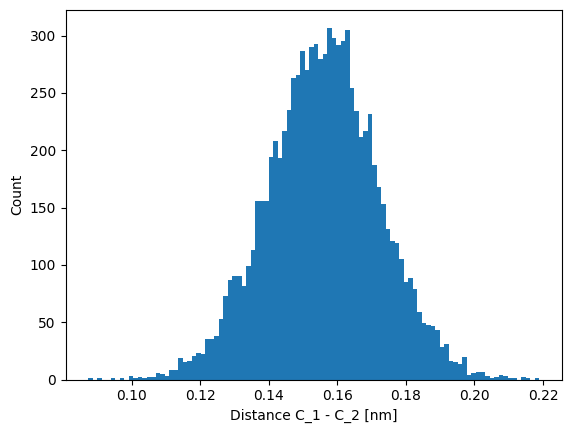

In [5]:
disp = jax.vmap(displacement_fn)(position_dataset[:, 0, :], position_dataset[:, 1, :])
dist_CC = jnp.sqrt(jnp.sum(disp ** 2, axis=-1))

plt.figure()
plt.hist(dist_CC, bins=100)
plt.xlabel("Distance C_1 - C_2 [nm]")
plt.ylabel("Count")

Indeed, the distance between the two carbon atoms is approximately
Gaussian distributed.
Hence, the choice of a harmonic potential model is reasonable.

Thus, we might estimate the parameters of the model by computing the mean and
variance of the particle distance.

$$
b_0 = \mathbb E[|\mathbf R_1 - \mathbf R_2|], \quad k_b = \frac{1}{\beta \operatorname{Var}[|\mathbf R_1 - \mathbf R_2|]}
$$

In [6]:
# Analytical solution
b0 = jnp.mean(dist_CC)
kb = kT / jnp.var(dist_CC)

print(f"Estimated potential parameters are {kb :.1f} kJ/mol/nm^2 and {b0 :.3f} nm")

Estimated potential parameters are 9693.3 kJ/mol/nm^2 and 0.156 nm


## Setup Optimizer

In [7]:
epochs = 100
initial_lr = 0.5
lr_decay = 0.1

lrd = int(position_dataset.shape[0] / epochs)
lr_schedule = optax.exponential_decay(initial_lr, lrd, lr_decay)
optimizer = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_schedule(lr_schedule),
    # Flips the sign of the update for gradient descend
    optax.scale_by_learning_rate(1.0),
)

## Setup Simulator

In [8]:
timings = ensemble.sampling.process_printouts(
    time_step=0.002, total_time=1e3, t_equilib=1e2,
    print_every=0.1, t_start=0.0
)

init_ref_state, sim_template = ensemble.sampling.initialize_simulator_template(
    simulate.nvt_langevin, shift_fn=shift_fn, nbrs=nbrs_init,
    init_with_PRNGKey=True, extra_simulator_kwargs={"kT": kT, "gamma": 1.0, "dt": 0.002}
)

cg_masses = masses[0]

reference_state = init_ref_state(
    random.PRNGKey(11), r_init,
    energy_or_force_fn=energy_fn_template(init_params),
    init_sim_kwargs={"mass": cg_masses, "neighbor": nbrs_init}
)

## Setup Relative Entropy Minimization

In [9]:
relative_entropy = RelativeEntropy(
    init_params=init_params, optimizer=optimizer,
    reweight_ratio=1.1, sim_batch_size=1,
    energy_fn_template=energy_fn_template,
)

subsampled_dataset = position_dataset[::100, ...]
print(f"Dataset has shape {subsampled_dataset.shape}")

relative_entropy.add_statepoint(
    position_dataset, energy_fn_template,
    sim_template, neighbor_fn, timings,
    {'kT': kT}, reference_state,  
)

relative_entropy.init_step_size_adaption(0.1)

Dataset has shape (90, 2, 3)
No reference batch size provided. Using number of generated CG snapshots by default.


/Users/paul/Lokal/chemtrain/chemtrain/ensemble/reweighting.py:777: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(
/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


Time for trajectory initialization 0: 0.0038750052452087404 mins
[Step size] Use 7 iterations for 10 interior points.


In [10]:
relative_entropy.train(epochs)

[Step Size] Found optimal step size 1.0 with residual 1.69264554977417



[RE] Epoch 0
	Mean Delta RE loss = 0.46431
	Gradient norm: 0.14550553262233734
	Elapsed time = 0.069 min
[Statepoint 0]
	kT = 2.564 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 1.19598388671875



[RE] Epoch 1
	Mean Delta RE loss = 1.50070
	Gradient norm: 24.406991958618164
	Elapsed time = 0.059 min
[Statepoint 0]
	kT = 2.597 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.038072109222412



[RE] Epoch 2
	Mean Delta RE loss = -0.13227
	Gradient norm: 2.9602198600769043
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.580 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.0931191444396973



[RE] Epoch 3
	Mean Delta RE loss = 0.07060
	Gradient norm: 33.6684455871582
	Elapsed time = 0.008 min
[Statepoint 0]
	kT = 2.554 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 1.8890833854675293



[RE] Epoch 4
	Mean Delta RE loss = -0.24193
	Gradient norm: 8.893223762512207
	Elapsed time = 0.010 min
[Statepoint 0]
	kT = 2.565 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.1107516288757324



[RE] Epoch 5
	Mean Delta RE loss = 0.05841
	Gradient norm: 1.6036288738250732
	Elapsed time = 0.007 min
[Statepoint 0]
	kT = 2.546 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.300546169281006



[RE] Epoch 6
	Mean Delta RE loss = 0.69102
	Gradient norm: 19.912639617919922
	Elapsed time = 0.007 min
[Statepoint 0]
	kT = 2.564 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.1906371116638184



[RE] Epoch 7
	Mean Delta RE loss = 0.62581
	Gradient norm: 16.731433868408203
	Elapsed time = 0.008 min
[Statepoint 0]
	kT = 2.586 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.172318935394287



[RE] Epoch 8
	Mean Delta RE loss = 0.15127
	Gradient norm: 2.527944803237915
	Elapsed time = 0.007 min
[Statepoint 0]
	kT = 2.567 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.226191997528076



[RE] Epoch 9
	Mean Delta RE loss = -0.17438
	Gradient norm: 0.6666352152824402
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.594 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2942042350769043



[RE] Epoch 10
	Mean Delta RE loss = -0.25704
	Gradient norm: 6.75494384765625
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.291734218597412



[RE] Epoch 11
	Mean Delta RE loss = -0.25817
	Gradient norm: 11.13673210144043
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.534 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.247230052947998



[RE] Epoch 12
	Mean Delta RE loss = -0.31259
	Gradient norm: 8.103449821472168
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.604 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2080130577087402



[RE] Epoch 13
	Mean Delta RE loss = -0.33501
	Gradient norm: 1.964651107788086
	Elapsed time = 0.009 min
[Statepoint 0]
	kT = 2.577 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2470803260803223



[RE] Epoch 14
	Mean Delta RE loss = -0.22193
	Gradient norm: 0.7772279977798462
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.555 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2999091148376465



[RE] Epoch 15
	Mean Delta RE loss = -0.03257
	Gradient norm: 9.466257095336914
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.647 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.26570463180542



[RE] Epoch 16
	Mean Delta RE loss = -0.04723
	Gradient norm: 12.82009220123291
	Elapsed time = 0.007 min
[Statepoint 0]
	kT = 2.506 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2268319129943848



[RE] Epoch 17
	Mean Delta RE loss = -0.30274
	Gradient norm: 4.190487384796143
	Elapsed time = 0.007 min
[Statepoint 0]
	kT = 2.486 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2430663108825684



[RE] Epoch 18
	Mean Delta RE loss = -0.55148
	Gradient norm: 0.28897106647491455
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.621 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2980265617370605



[RE] Epoch 19
	Mean Delta RE loss = -0.64588
	Gradient norm: 8.430623054504395
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.550 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.270982265472412



[RE] Epoch 20
	Mean Delta RE loss = -0.69046
	Gradient norm: 12.95241928100586
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.544 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2128891944885254



[RE] Epoch 21
	Mean Delta RE loss = -0.76470
	Gradient norm: 4.372643947601318
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.633 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2557902336120605



[RE] Epoch 22
	Mean Delta RE loss = -0.73104
	Gradient norm: 1.2244025468826294
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.629 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2955899238586426



[RE] Epoch 23
	Mean Delta RE loss = -0.61595
	Gradient norm: 16.02248764038086
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.643 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2311644554138184



[RE] Epoch 24
	Mean Delta RE loss = -0.71463
	Gradient norm: 10.673898696899414
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.531 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2496800422668457



[RE] Epoch 25
	Mean Delta RE loss = -0.89454
	Gradient norm: 0.0731111541390419
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.639 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3022122383117676



[RE] Epoch 26
	Mean Delta RE loss = -0.92942
	Gradient norm: 10.889283180236816
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.575 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2559380531311035



[RE] Epoch 27
	Mean Delta RE loss = -0.94362
	Gradient norm: 11.357768058776855
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.552 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2421507835388184



[RE] Epoch 28
	Mean Delta RE loss = -0.95229
	Gradient norm: 0.33922281861305237
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.502 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.301283359527588



[RE] Epoch 29
	Mean Delta RE loss = -0.85662
	Gradient norm: 8.027220726013184
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.501 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2732443809509277



[RE] Epoch 30
	Mean Delta RE loss = -0.83401
	Gradient norm: 11.496160507202148
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.521 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.260648250579834



[RE] Epoch 31
	Mean Delta RE loss = -0.93252
	Gradient norm: 1.0126227140426636
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.621 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.297847270965576



[RE] Epoch 32
	Mean Delta RE loss = -0.97350
	Gradient norm: 3.827704906463623
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.537 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.293562412261963



[RE] Epoch 33
	Mean Delta RE loss = -0.96241
	Gradient norm: 8.058612823486328
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.495 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2756762504577637



[RE] Epoch 34
	Mean Delta RE loss = -0.95570
	Gradient norm: 2.4031059741973877
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.567 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.290210247039795



[RE] Epoch 35
	Mean Delta RE loss = -0.90425
	Gradient norm: 0.5543835759162903
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.526 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3023571968078613



[RE] Epoch 36
	Mean Delta RE loss = -0.83900
	Gradient norm: 4.060449123382568
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.493 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2906670570373535



[RE] Epoch 37
	Mean Delta RE loss = -0.83091
	Gradient norm: 4.558497905731201
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.638 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.287458896636963



[RE] Epoch 38
	Mean Delta RE loss = -0.87685
	Gradient norm: 0.40644362568855286
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.667 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.298466205596924



[RE] Epoch 39
	Mean Delta RE loss = -0.90500
	Gradient norm: 0.8309930562973022
	Elapsed time = 0.007 min
[Statepoint 0]
	kT = 2.586 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3022170066833496



[RE] Epoch 40
	Mean Delta RE loss = -0.90446
	Gradient norm: 2.9303343296051025
	Elapsed time = 0.006 min
[Statepoint 0]
	kT = 2.532 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2962355613708496



[RE] Epoch 41
	Mean Delta RE loss = -0.89379
	Gradient norm: 2.2445690631866455
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.592 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.29335355758667



[RE] Epoch 42
	Mean Delta RE loss = -0.87306
	Gradient norm: 0.3976753056049347
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.524 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.2991976737976074



[RE] Epoch 43
	Mean Delta RE loss = -0.83553
	Gradient norm: 0.4246998429298401
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.586 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025803565979004



[RE] Epoch 44
	Mean Delta RE loss = -0.80548
	Gradient norm: 1.4895868301391602
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.517 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.299630641937256



[RE] Epoch 45
	Mean Delta RE loss = -0.80298
	Gradient norm: 1.8220791816711426
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.532 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.296996593475342



[RE] Epoch 46
	Mean Delta RE loss = -0.83055
	Gradient norm: 0.4951845109462738
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.596 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.299342632293701



[RE] Epoch 47
	Mean Delta RE loss = -0.86166
	Gradient norm: 0.04056096822023392
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.623 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3023533821105957



[RE] Epoch 48
	Mean Delta RE loss = -0.87880
	Gradient norm: 0.9568777680397034
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.496 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.301805019378662



[RE] Epoch 49
	Mean Delta RE loss = -0.88438
	Gradient norm: 1.2937185764312744
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.543 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.299389362335205



[RE] Epoch 50
	Mean Delta RE loss = -0.88313
	Gradient norm: 0.809322714805603
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.498 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.299487590789795



[RE] Epoch 51
	Mean Delta RE loss = -0.87240
	Gradient norm: 0.013178685680031776
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.559 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3017163276672363



[RE] Epoch 52
	Mean Delta RE loss = -0.85716
	Gradient norm: 0.30010589957237244
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.558 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3024067878723145



[RE] Epoch 53
	Mean Delta RE loss = -0.84867
	Gradient norm: 1.1466858386993408
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.592 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3007922172546387



[RE] Epoch 54
	Mean Delta RE loss = -0.85951
	Gradient norm: 0.804693341255188
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.625 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3004393577575684



[RE] Epoch 55
	Mean Delta RE loss = -0.88203
	Gradient norm: 0.08093190938234329
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.545 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.301684856414795



[RE] Epoch 56
	Mean Delta RE loss = -0.90111
	Gradient norm: 0.12642493844032288
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.541 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025612831115723



[RE] Epoch 57
	Mean Delta RE loss = -0.91225
	Gradient norm: 0.49474823474884033
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.601 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3021302223205566



[RE] Epoch 58
	Mean Delta RE loss = -0.91611
	Gradient norm: 0.5652409791946411
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.570 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3015856742858887



[RE] Epoch 59
	Mean Delta RE loss = -0.91263
	Gradient norm: 0.13772520422935486
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.623 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3016066551208496



[RE] Epoch 60
	Mean Delta RE loss = -0.90514
	Gradient norm: 0.007427164353430271
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.604 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302253246307373



[RE] Epoch 61
	Mean Delta RE loss = -0.89688
	Gradient norm: 0.09003090113401413
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.523 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302577495574951



[RE] Epoch 62
	Mean Delta RE loss = -0.89212
	Gradient norm: 0.32082200050354004
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.586 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302323818206787



[RE] Epoch 63
	Mean Delta RE loss = -0.89490
	Gradient norm: 0.19765697419643402
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.569 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302018642425537



[RE] Epoch 64
	Mean Delta RE loss = -0.90329
	Gradient norm: 0.09963271021842957
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.600 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3022475242614746



[RE] Epoch 65
	Mean Delta RE loss = -0.91338
	Gradient norm: 0.004822018090635538
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.567 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3024630546569824



[RE] Epoch 66
	Mean Delta RE loss = -0.92058
	Gradient norm: 0.03647816926240921
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.591 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302581310272217



[RE] Epoch 67
	Mean Delta RE loss = -0.92511
	Gradient norm: 0.14709219336509705
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.566 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302490711212158



[RE] Epoch 68
	Mean Delta RE loss = -0.92573
	Gradient norm: 0.09084843099117279
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.587 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302372455596924



[RE] Epoch 69
	Mean Delta RE loss = -0.92304
	Gradient norm: 0.041303928941488266
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.579 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3024439811706543



[RE] Epoch 70
	Mean Delta RE loss = -0.91840
	Gradient norm: 0.0020019356161355972
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.557 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302537441253662



[RE] Epoch 71
	Mean Delta RE loss = -0.91421
	Gradient norm: 0.021195000037550926
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.483 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025155067443848



[RE] Epoch 72
	Mean Delta RE loss = -0.91022
	Gradient norm: 0.29772642254829407
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.729 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3024306297302246



[RE] Epoch 73
	Mean Delta RE loss = -0.91236
	Gradient norm: 0.030812950804829597
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.591 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3024563789367676



[RE] Epoch 74
	Mean Delta RE loss = -0.91645
	Gradient norm: 0.0015621858183294535
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.580 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025574684143066



[RE] Epoch 75
	Mean Delta RE loss = -0.91985
	Gradient norm: 0.035889048129320145
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.612 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302579402923584



[RE] Epoch 76
	Mean Delta RE loss = -0.92095
	Gradient norm: 0.06691400706768036
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.494 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302518367767334



[RE] Epoch 77
	Mean Delta RE loss = -0.91909
	Gradient norm: 0.07292872667312622
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.554 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.30253267288208



[RE] Epoch 78
	Mean Delta RE loss = -0.91547
	Gradient norm: 1.2806281119992491e-05
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.560 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302506923675537



[RE] Epoch 79
	Mean Delta RE loss = -0.91236
	Gradient norm: 0.013716545887291431
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.541 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302548885345459



[RE] Epoch 80
	Mean Delta RE loss = -0.90838
	Gradient norm: 0.0081621203571558
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.560 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025755882263184



[RE] Epoch 81
	Mean Delta RE loss = -0.90553
	Gradient norm: 0.012603219598531723
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.547 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025736808776855



[RE] Epoch 82
	Mean Delta RE loss = -0.90341
	Gradient norm: 0.06289057433605194
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.598 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025641441345215



[RE] Epoch 83
	Mean Delta RE loss = -0.90366
	Gradient norm: 0.00964263640344143
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.564 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302525043487549



[RE] Epoch 84
	Mean Delta RE loss = -0.90445
	Gradient norm: 0.03756815567612648
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.578 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025288581848145



[RE] Epoch 85
	Mean Delta RE loss = -0.90597
	Gradient norm: 0.0004589617601595819
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.646 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025736808776855



[RE] Epoch 86
	Mean Delta RE loss = -0.90727
	Gradient norm: 0.02740626037120819
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.558 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025832176208496



[RE] Epoch 87
	Mean Delta RE loss = -0.90759
	Gradient norm: 0.016031775623559952
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.657 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025736808776855



[RE] Epoch 88
	Mean Delta RE loss = -0.90797
	Gradient norm: 0.045033056288957596
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.539 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025574684143066



[RE] Epoch 89
	Mean Delta RE loss = -0.90695
	Gradient norm: 0.015362126752734184
	Elapsed time = 0.005 min
[Statepoint 0]
	kT = 2.546 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025546073913574



[RE] Epoch 90
	Mean Delta RE loss = -0.90558
	Gradient norm: 0.002629705471917987
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.509 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025660514831543



[RE] Epoch 91
	Mean Delta RE loss = -0.90397
	Gradient norm: 0.0008668584050610662
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.559 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025689125061035



[RE] Epoch 92
	Mean Delta RE loss = -0.90250
	Gradient norm: 0.00019140679796691984
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.535 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025851249694824



[RE] Epoch 93
	Mean Delta RE loss = -0.90089
	Gradient norm: 0.04572681710124016
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.576 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302565097808838



[RE] Epoch 94
	Mean Delta RE loss = -0.90085
	Gradient norm: 0.07125427573919296
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.626 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025641441345215



[RE] Epoch 95
	Mean Delta RE loss = -0.90220
	Gradient norm: 0.00211071758531034
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.532 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302537441253662



[RE] Epoch 96
	Mean Delta RE loss = -0.90329
	Gradient norm: 0.0236463975161314
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.641 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025641441345215



[RE] Epoch 97
	Mean Delta RE loss = -0.90550
	Gradient norm: 0.007483238819986582
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.488 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.3025765419006348



[RE] Epoch 98
	Mean Delta RE loss = -0.90696
	Gradient norm: 0.0036234266590327024
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.559 ref_kT = 2.560


[Step Size] Found optimal step size 1.0 with residual 2.302581310272217



[RE] Epoch 99
	Mean Delta RE loss = -0.90760
	Gradient norm: 0.07393365353345871
	Elapsed time = 0.004 min
[Statepoint 0]
	kT = 2.547 ref_kT = 2.560


## Results

Text(0, 0.5, 'Gradient Norm')

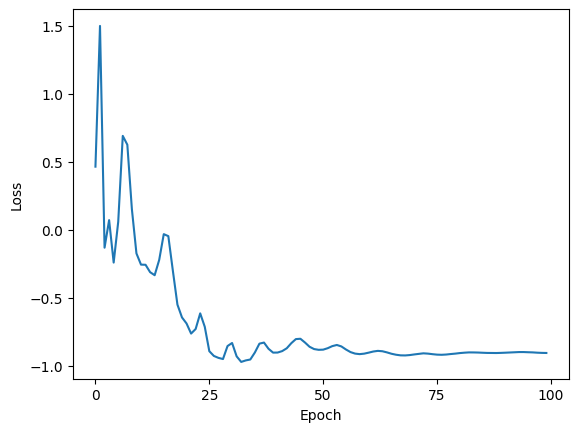

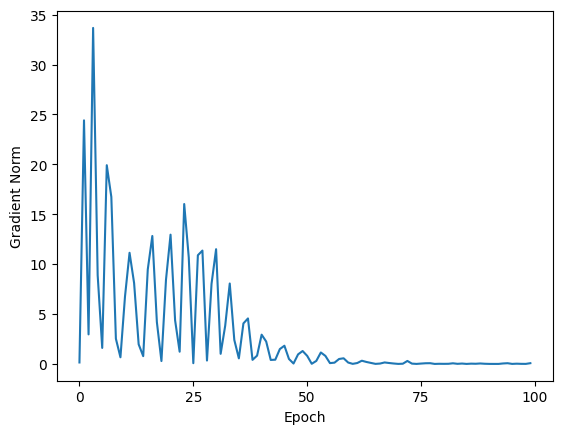

In [11]:
plt.figure()
plt.plot(relative_entropy.delta_re[0])
plt.xticks(ticks=range(0, epochs + 1, 25))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.figure()
plt.plot(relative_entropy.gradient_norm_history)
plt.xticks(ticks=range(0, epochs + 1, 25))
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")

Finally, we compare the values obtained from a Gaussian fit to those obtained from relative entropy minimization.

In [12]:
pred_parameters = tree_util.tree_map(jnp.exp, relative_entropy.params)

b0_err = jnp.abs(b0 - pred_parameters["log_b0"])
kb_err = jnp.abs(kb - pred_parameters["log_kb"])

print(f"RE min. predicted {pred_parameters['log_b0']:.3f} nm and {pred_parameters['log_kb']:.1f} kJ/mol/nm^2")
print(f"Gaussian fit predicted {b0:.3f} nm and {kb:.1f} kJ/mol/nm^2")
print(f"Absolute error in b0 is {b0_err:.3f} nm and in kb is {kb_err:.1f} kJ/mol/nm^2")

RE min. predicted 0.152 nm and 9485.1 kJ/mol/nm^2
Gaussian fit predicted 0.156 nm and 9693.3 kJ/mol/nm^2
Absolute error in b0 is 0.004 nm and in kb is 208.2 kJ/mol/nm^2


## Further Reading

### Examples

- [Alanine Dipeptide in Implicit Water](../examples/CG_alanine_dipeptide)

### Publications

1. Stephan Thaler, Maximilian Stupp, Julija Zavadlav; *Deep coarse-grained potentials via relative entropy minimization*. J. Chem. Phys. 28 December 2022; 157 (24): 244103. <https://doi.org/10.1063/5.0124538>

## References

[^Shell2008]: Shell, M. S. The Relative Entropy Is Fundamental to Multiscale and Inverse Thermodynamic Problems. _J. Chem. Phys._ **2008**, _129_ (14), 144108. [https://doi.org/10.1063/1.2992060](https://doi.org/10.1063/1.2992060).
[^Carmichael2012]: Carmichael, S. P.; Shell, M. S. A New Multiscale Algorithm and Its Application to Coarse-Grained Peptide Models for Self-Assembly. _J. Phys. Chem. B_ **2012**, _116_ (29), 8383–8393. [https://doi.org/10.1021/jp2114994](https://doi.org/10.1021/jp2114994).
[^Noid2008]: Noid, W. G.; Chu, J.-W.; Ayton, G. S.; Krishna, V.; Izvekov, S.; Voth, G. A.; Das, A.; Andersen, H. C. The Multiscale Coarse-Graining Method. I. A Rigorous Bridge between Atomistic and Coarse-Grained Models. _J Chem Phys_ **2008**, _128_ (24), 244114. [https://doi.org/10.1063/1.2938860](https://doi.org/10.1063/1.2938860).